In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import os
import calendar
import time
from matplotlib import cm
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
## Loading our csv file

os.chdir("I:\My Machine Learning\My Python projects\Ecommerce Analytics")
df = pd.read_excel("E-com_Data.xlsx")
print('Our dataset has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

Our dataset has 537979 rows and 12 columns


In [3]:
df.head()

,CustomerID,Item Code,InvoieNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177,2017-10-29,6,15:36:00,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422,2017-10-05,2,14:53:00,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422,2017-10-12,2,14:53:00,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633,2017-08-22,3,14:47:00,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422,2017-10-10,2,14:53:00,944.0,1888.0,Location 1,NaN,NaN,NaN


# Understanding our data and taking necessary steps to clean

In [4]:
## Checking for missing values

def missing_values_table(df):
        # Total missing values
        missing_values = df.isnull().sum()
        
        # Percentage of missing values
        missing_values_percentage = 100 * (df.isnull().sum() / len(df))
        
        # Make a table with the results
        missing_value_table = pd.concat([missing_values, missing_values_percentage], axis=1)
        
        # Rename the columns
        missing_values_table_rename = missing_value_table.rename(columns = {0 : "Missing Values", 1 : "% of Total Values"})
        
        # Sort the table by percentage of missing descending
        missing_values_table_rename = missing_values_table_rename[
            missing_values_table_rename.iloc[:,1] != 0].sort_values(
        "% of Total Values", ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(missing_values_table_rename.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return missing_values_table_rename

missing_values_table(df)

Your selected dataframe has 12 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Sold as set,537979,100.0
Cancelled_status,529634,98.4
Reason of return,529631,98.4
CustomerID,133790,24.9


In [5]:
## Dropping sold as set column

df = df.drop(['Sold as set'], axis = 1)
df.head()

,CustomerID,Item Code,InvoieNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return
0,4355.0,15734,398177,2017-10-29,6,15:36:00,321.0,1926.0,Location 1,NaN,NaN
1,4352.0,14616,394422,2017-10-05,2,14:53:00,870.0,1740.0,Location 1,NaN,NaN
2,4352.0,14614,394422,2017-10-12,2,14:53:00,933.0,1866.0,Location 1,NaN,NaN
3,4352.0,85014B,388633,2017-08-22,3,14:47:00,623.0,1869.0,Location 1,NaN,NaN
4,4352.0,15364,394422,2017-10-10,2,14:53:00,944.0,1888.0,Location 1,NaN,NaN


In [6]:
df['Cancelled_status'] = df['Cancelled_status'].fillna('False', axis = 0)

In [7]:
df['Cancelled_status'].nunique()

2

In [8]:
missing_values_table(df)

Your selected dataframe has 11 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Reason of return,529631,98.4
CustomerID,133790,24.9


While looking at the number of null values in the dataframe, it is interesting to note that ∼ 25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe

In [9]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions after removing the null values from CustomerID:', df.shape)

Dataframe dimensions after removing the null values from CustomerID: (404189, 11)


We still have reason of return, unfortunately we don't have any way to get that data. The reason might be anything, defective goods, wrong order etc. We can impute a string value - `Misc` where the `Cancelled_status` is `TRUE`. For the rest we will put string `No returns`

In [10]:
df['Reason of return'] = df['Reason of return'].fillna('No Return', axis = 0)

In [11]:
missing_values_table(df)

Your selected dataframe has 11 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


We have successfully removed or imputed all the missing values. Let's check for duplicate entries

In [12]:
print("There are {} duplicate entries in the data set provided".format(df.duplicated().sum()))

There are 8 duplicate entries in the data set provided


Let us drop these duplicate entries:

In [13]:
df.drop_duplicates(inplace = True)

In [14]:
print("There are {} duplicate entries in the data set after removing duplicates".format(df.duplicated().sum()))

There are 0 duplicate entries in the data set after removing duplicates


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404181 entries, 0 to 537949
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   CustomerID         404181 non-null  float64       
 1   Item Code          404181 non-null  object        
 2   InvoieNo           404181 non-null  int64         
 3   Date of purchase   404181 non-null  datetime64[ns]
 4   Quantity           404181 non-null  int64         
 5   Time               404181 non-null  object        
 6   price per Unit     404181 non-null  float64       
 7   Price              404181 non-null  float64       
 8   Shipping Location  404181 non-null  object        
 9   Cancelled_status   404181 non-null  object        
 10  Reason of return   404181 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 37.0+ MB


Lets rename our columns so that it is easier to code

In [16]:
df.columns = ['customer_id', 'item_code', 'invoice_no', 'date_of_purchase', 'quantity', 'time', 'price_per_unit', 'total_sales',
             'location', 'is_cancelled', 'return_reason']

In [17]:
import dateutil
import datetime as dt
#convert time from object datatype to date times
df['invoice_date']=df.apply(lambda r : pd.datetime.combine(r['date_of_purchase'],r['time']),1)

In [18]:
df['time'] = pd.to_datetime(df['time'], format = '%H:%M:%S')

# Exploratory Data Analysis

##  Is company’s performance improving or degrading over time? 

Company’s performance can be measured in many terms. Here, we will be analysing the performance by:

1. Growth in Revenue by Sales
2. Growth in Sales Quantity
3. Growth in Customer Base

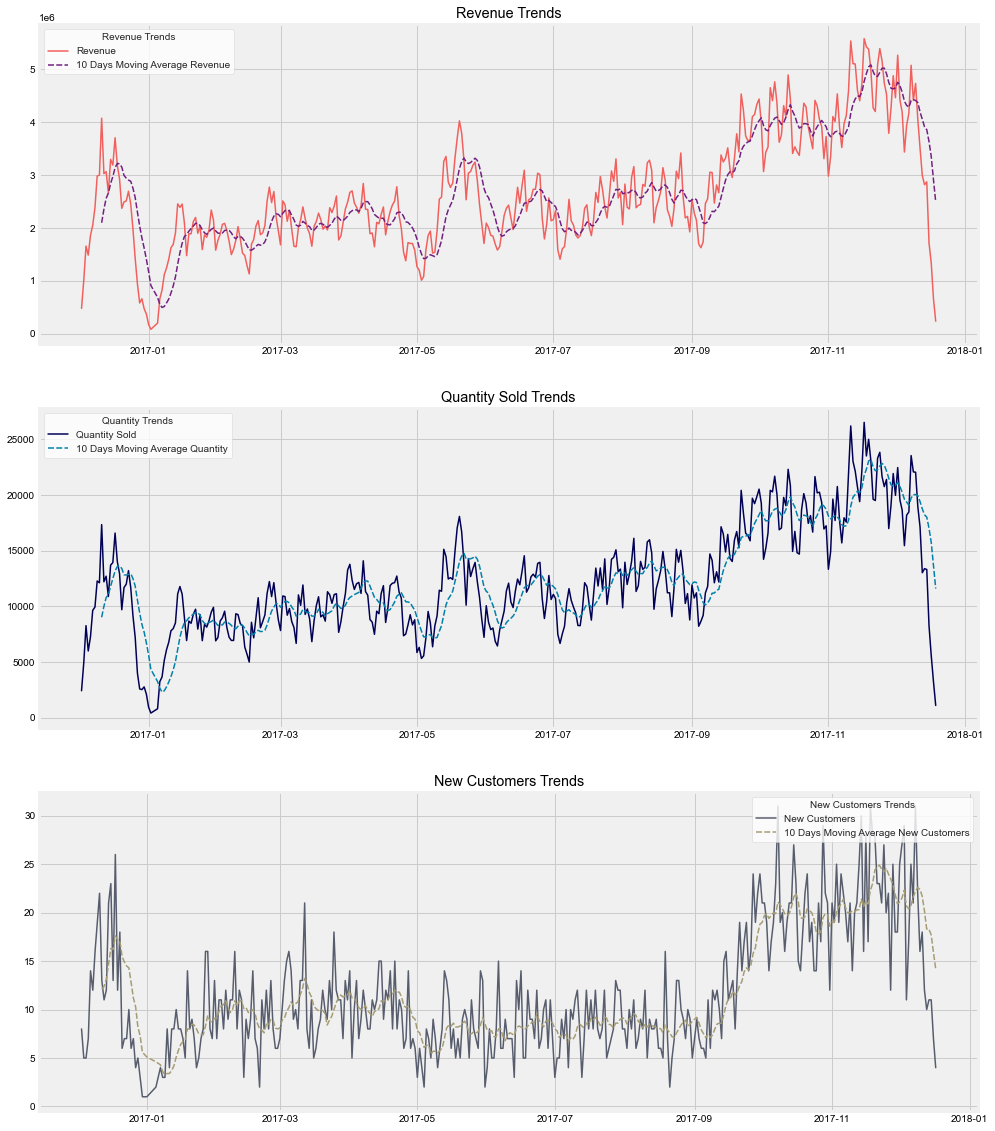

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,20))
rev = df[df['total_sales']>=0]

rev = rev.groupby(rev['date_of_purchase']).agg({'total_sales':'sum',
                                                  'quantity': 'sum',
                                                  'customer_id': 'count'})

rev['10 Days Moving Average Revenue'] = rev['total_sales'].rolling(10).mean()
rev['10 Days Moving Average Quantity'] = rev['quantity'].rolling(10).mean()

cust = df.groupby('customer_id').first().reset_index()[['customer_id','date_of_purchase']]
cust = cust.groupby(cust['date_of_purchase']).agg({'customer_id':'count'})
cust['10 Days Moving Average Quantity'] = cust['customer_id'].rolling(10).mean()

sns.set_style("whitegrid")
sns.lineplot(data=rev[['total_sales','10 Days Moving Average Revenue']], palette='magma_r', linewidth=1.5, ax=ax[0],legend=False)
ax[0].legend(title='Revenue Trends', loc='upper left', labels=['Revenue', '10 Days Moving Average Revenue'])
ax[0].title.set_text('Revenue Trends')
ax[0].set_xlabel('')

sns.lineplot(data=rev[['quantity','10 Days Moving Average Quantity']], palette='ocean', linewidth=1.5, ax=ax[1])
ax[1].legend(title='Quantity Trends', loc='upper left', labels=['Quantity Sold', '10 Days Moving Average Quantity'])
ax[1].title.set_text('Quantity Sold Trends')
ax[1].set_xlabel('')

sns.lineplot(data=cust, palette='cividis', linewidth=1.5, ax=ax[2])
ax[2].legend(title='New Customers Trends', loc='upper right', labels=['New Customers', '10 Days Moving Average New Customers'])
ax[2].title.set_text('New Customers Trends')
ax[2].set_xlabel('')


plt.show()

We can see a drop in 12/2017 as the data we have is not for the complete month, but overall it seems are company is doing well

In [20]:
## Let us understand the time frame we have

period = df['date_of_purchase'].max() - df['date_of_purchase'].min()
print(period,'days')
print("Datafile starts with timepoint {}".format(df['date_of_purchase'].min()))
print("Datafile ends with timepoint {}".format(df['date_of_purchase'].max()))

382 days 00:00:00 days
Datafile starts with timepoint 2016-12-02 00:00:00
Datafile ends with timepoint 2017-12-19 00:00:00


In [21]:
# df.insert(loc=2, column='year', value=df['date_of_purchase'].map(lambda x: x.year))
# df.insert(loc=3, column='month', value=df.date_of_purchase.dt.month)
# # 01/12/2012 was a wednesday so it is the third day, if we just convert it it will come as day 1, so keeping monday as 1 ... Sunday = 7
# df.insert(loc=4, column='day', value=(df.date_of_purchase.dt.dayofweek)+1)

In [22]:
df.head()

,customer_id,item_code,invoice_no,date_of_purchase,quantity,time,price_per_unit,total_sales,location,is_cancelled,return_reason,invoice_date
0,4355.0,15734,398177,2017-10-29,6,1900-01-01 15:36:00,321.0,1926.0,Location 1,False,No Return,2017-10-29 15:36:00
1,4352.0,14616,394422,2017-10-05,2,1900-01-01 14:53:00,870.0,1740.0,Location 1,False,No Return,2017-10-05 14:53:00
2,4352.0,14614,394422,2017-10-12,2,1900-01-01 14:53:00,933.0,1866.0,Location 1,False,No Return,2017-10-12 14:53:00
3,4352.0,85014B,388633,2017-08-22,3,1900-01-01 14:47:00,623.0,1869.0,Location 1,False,No Return,2017-08-22 14:47:00
4,4352.0,15364,394422,2017-10-10,2,1900-01-01 14:53:00,944.0,1888.0,Location 1,False,No Return,2017-10-10 14:53:00


### Understanding trends by month

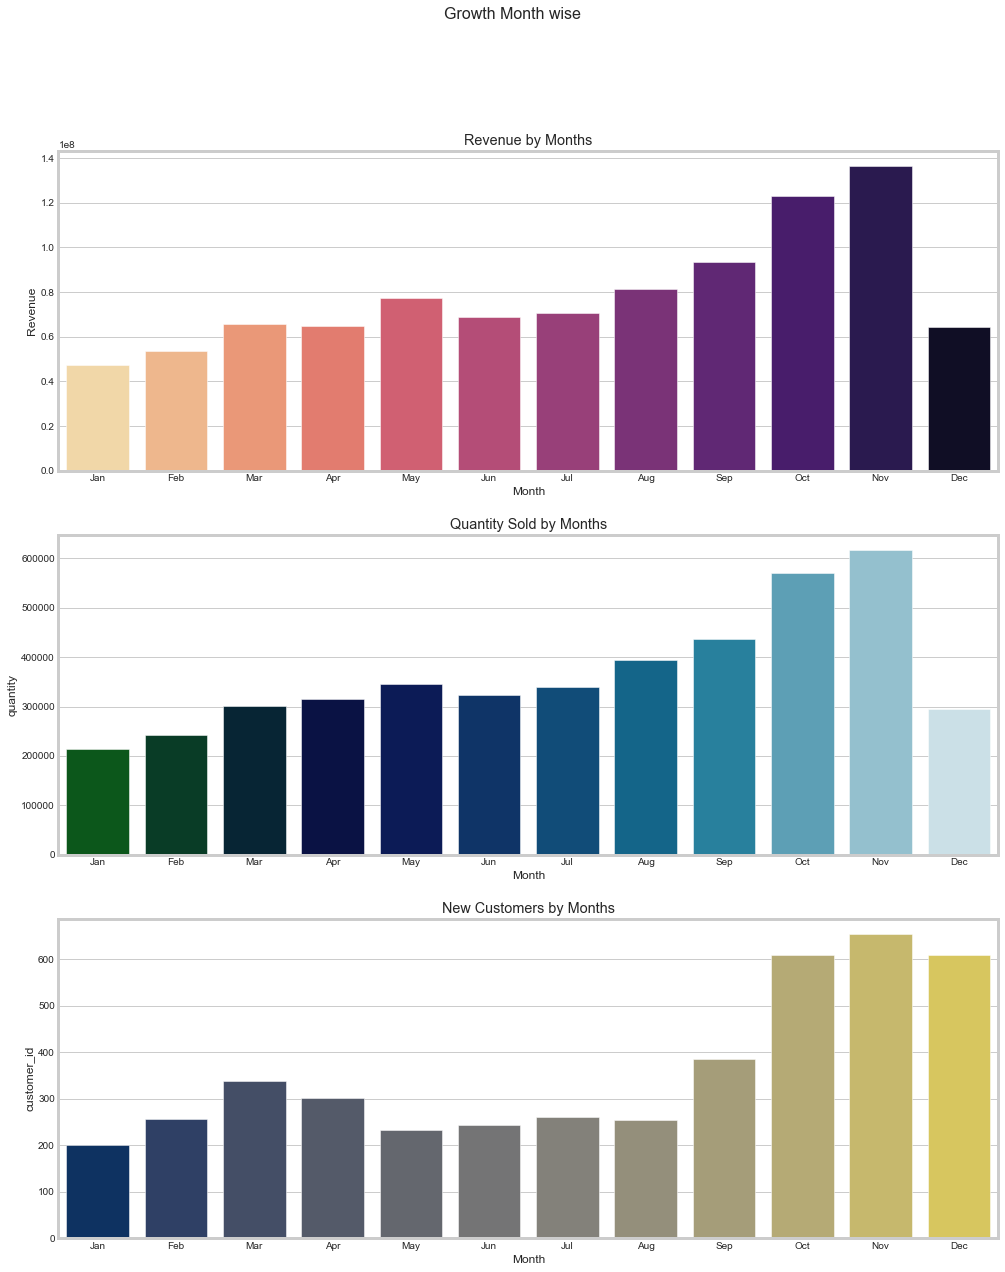

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,20))

## making a dataframe with only positive sale and we need to analyse the year 2017
rev = df[(df['total_sales']>0)&(df['date_of_purchase'].dt.year==2017)]
rev = rev.groupby(rev['date_of_purchase'].dt.month).agg({'total_sales':'sum',
                                                  'quantity': 'sum',
                                                  'customer_id': 'count'})
## The index was all mixed up, so I resetted it
rev = rev.reset_index()

## making a new column = Month in our new dataframe
rev['Month'] = rev['date_of_purchase'].apply(lambda x: calendar.month_abbr[x])
rev = rev.rename({'total_sales':'Revenue'},axis=1)
cust = df.groupby('customer_id').first().reset_index()[['customer_id','date_of_purchase']]
cust = cust.groupby(cust.date_of_purchase.dt.month).agg({'customer_id':'count'})
cust = cust.reset_index()
cust['Month'] = cust['date_of_purchase'].apply(lambda x: calendar.month_abbr[x])


sns.set_style("whitegrid")
sns.barplot(data=rev, x=rev.Month, y='Revenue', palette='magma_r', ax=ax[0])
ax[0].title.set_text('Revenue by Months')


sns.barplot(data=rev, x=rev.Month, y='quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold by Months')


sns.barplot(data=cust, x=cust.Month, y='customer_id',  palette='cividis', ax=ax[2])
ax[2].title.set_text('New Customers by Months')
fig.suptitle('Growth Month wise',fontsize=16)



plt.show()

### Inferences:

1. It seems that company’s performance is improving in terms of revenue and sales, but as we are provided with just one year of data, it is hard to claim this for sure
2. There might be a seasonal rise during the end of the year.
3. In terms of new customer acquisition, we can see a clear upward slope.

Comparing Dec, 2016 and 2017 as we didn't do it previously

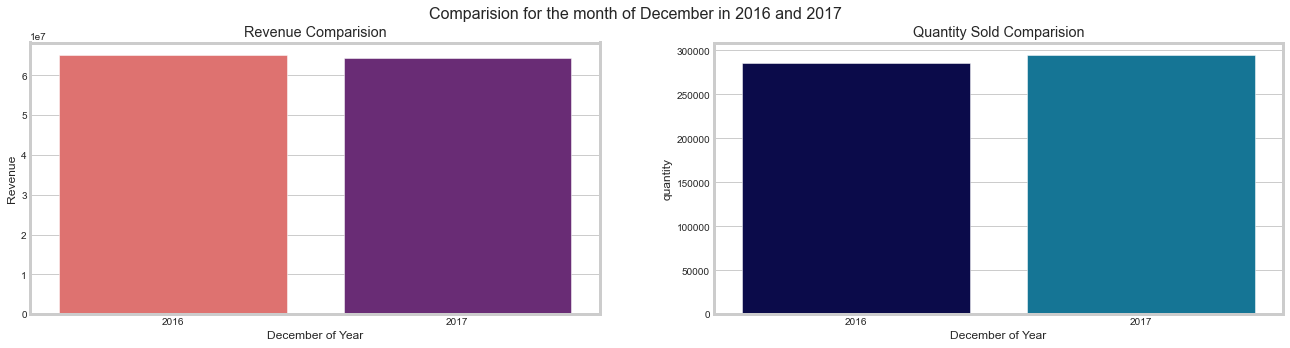

In [24]:
sales_comp = df[(df['date_of_purchase'].dt.month==12)&(df['total_sales']>=0)][['date_of_purchase','total_sales','quantity']]

sales_comp = sales_comp.groupby(sales_comp['date_of_purchase'].dt.year)[['total_sales','quantity']].sum()
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,5))

sns.set_style("whitegrid")
sns.barplot(data=sales_comp, x=sales_comp.index, y='total_sales', palette='magma_r', ax=ax[0])
ax[0].title.set_text('Revenue Comparision')
ax[0].set_ylabel('Revenue')
ax[0].set_xlabel('December of Year')

sns.barplot(data=sales_comp, x=sales_comp.index, y='quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold Comparision')
ax[1].set_xlabel('December of Year')


fig.suptitle('Comparision for the month of December in 2016 and 2017',fontsize=16)

plt.show()

In [25]:
print("Sales Revenue Difference: {:2.2f}% decline in revenue from 2016 \nSales Quantity Difference: {:2.2f}% increase in quantity from 2016".format(
((sales_comp['total_sales'][2016] - sales_comp['total_sales'][2017]) / sales_comp['total_sales'][2016])*100,
    ((sales_comp['quantity'][2016] - sales_comp['quantity'][2017]) / sales_comp['quantity'][2016])*100
))

Sales Revenue Difference: 1.08% decline in revenue from 2016 
Sales Quantity Difference: -3.05% increase in quantity from 2016


We have sold more units, but the revenue generated is a bit less

### Number of units sold per location

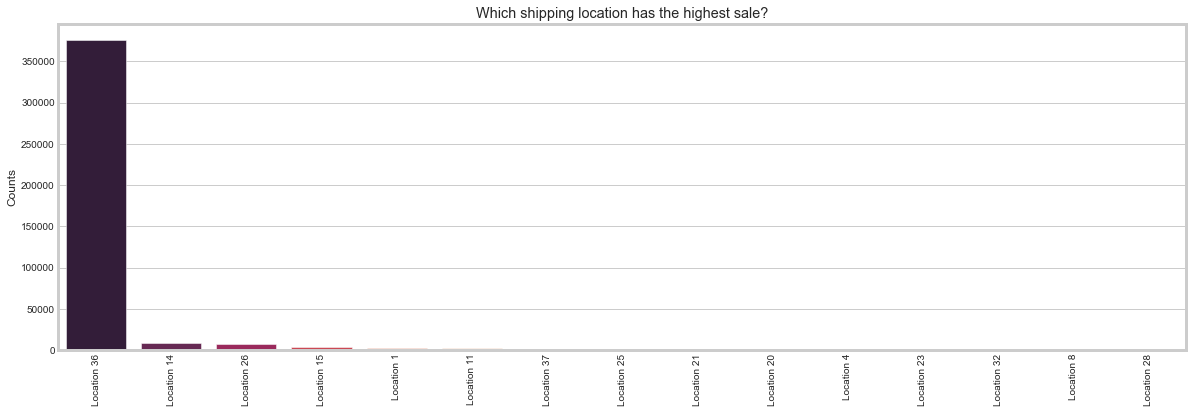

In [26]:
## Lets look at the sales in locations
location_counts = df['location'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(location_counts.index, location_counts.values, palette=sns.color_palette("rocket"))
plt.ylabel("Counts")
plt.title("Which shipping location has the highest sale?");
plt.xticks(rotation=90);

Location 36 is dominating the charts, lets remove that particular location and look into the other locations

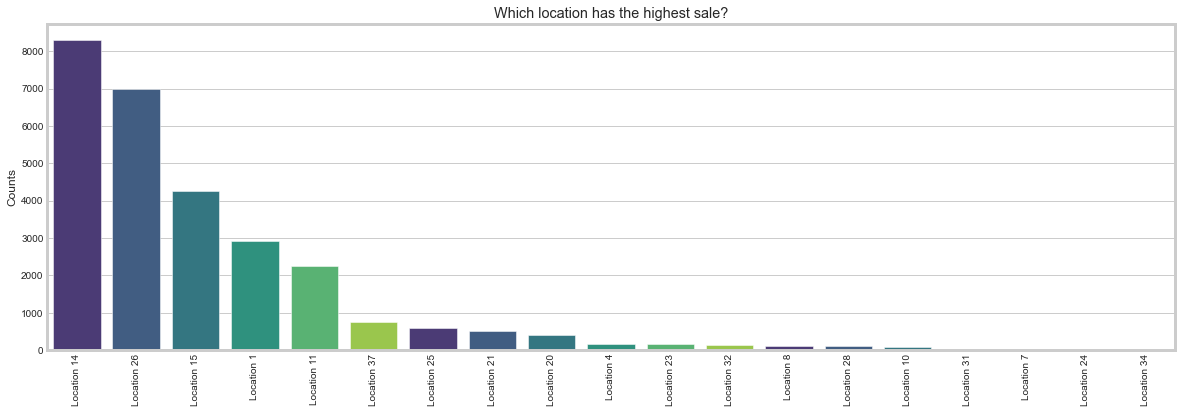

In [27]:
location_counts = df[df['location'] != 'Location 36']['location'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(18,6))
sns.barplot(location_counts.index, location_counts.values, palette=sns.color_palette("viridis"))
plt.ylabel("Counts")
plt.title("Which location has the highest sale?");
plt.xticks(rotation=90);

Location 14 is the highest after 36

The issue is that the sales are to imbalanced, some loacations just dominate others and we cannot see a clear picture. Let us create a charts with log scale

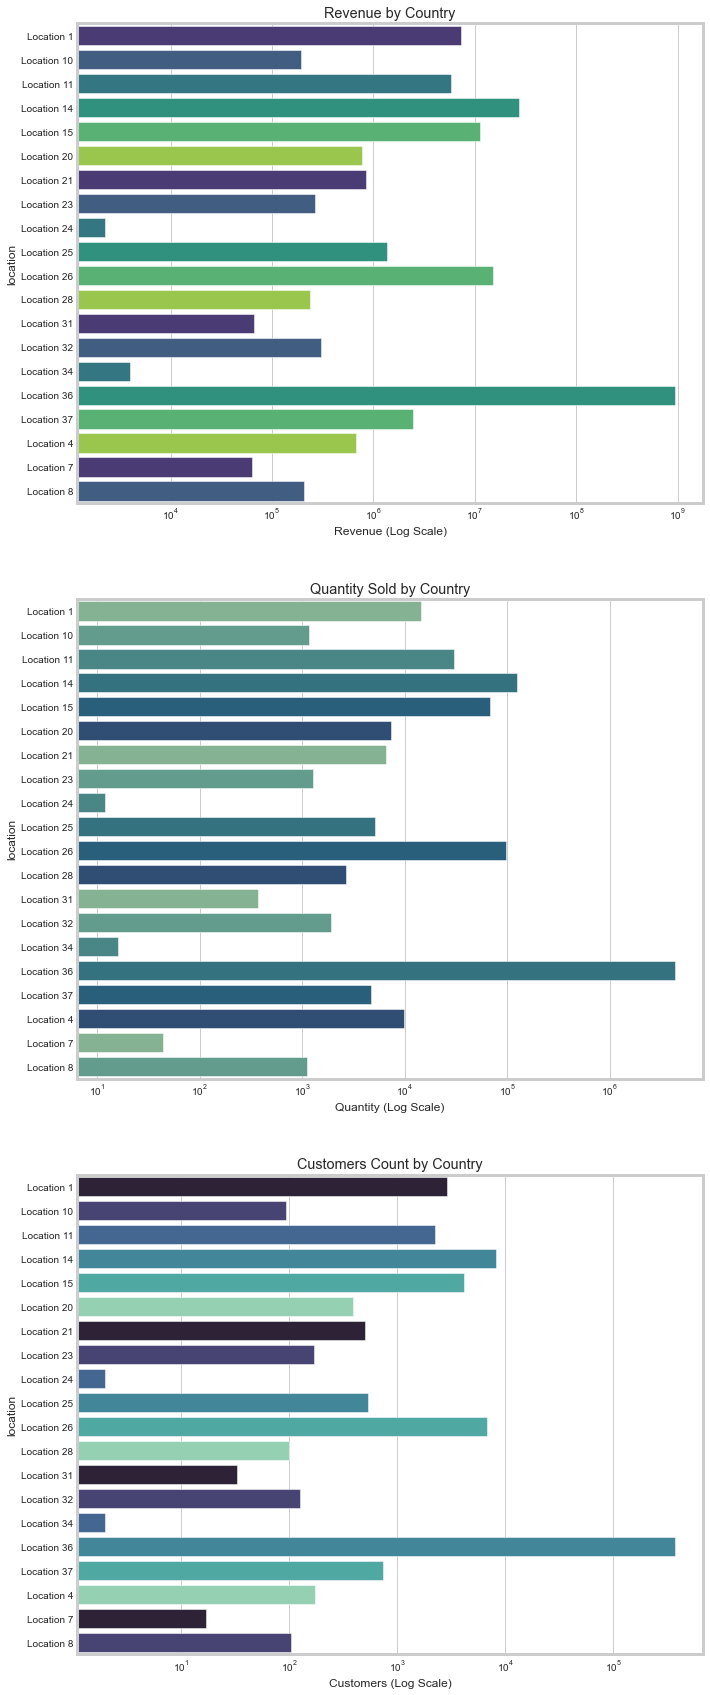

In [28]:
## Again creating a dataframe with only positive values
region = df[df['total_sales']>=0].groupby('location').agg({'total_sales':'sum',
                                                  'quantity': 'sum',
                                                  'customer_id': 'count'})

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,30))
g1 = sns.barplot(x=region['total_sales'], y=region.index, alpha=1, ax=ax[0], palette = sns.color_palette("viridis"), orient='h')
ax[0].title.set_text('Revenue by Country')
ax[0].set_xlabel("Revenue (Log Scale)")
g1.set_xscale("log")

g2 = sns.barplot(x=region['quantity'], y=region.index, alpha=1, ax=ax[1], palette=sns.color_palette("crest"),orient='h')
ax[1].title.set_text('Quantity Sold by Country')
ax[1].set_xlabel("Quantity (Log Scale)")
g2.set_xscale("log")

g3 = sns.barplot(x=region['customer_id'], y=region.index, alpha=1, ax=ax[2], palette=sns.color_palette("mako"), orient='h')
ax[2].title.set_text('Customers Count by Country')
ax[2].set_xlabel("Customers (Log Scale)")
g3.set_xscale("log")
plt.show()

This gives us more clear picture about the sales per location

### Sales and Quantity sold hourly and day basis

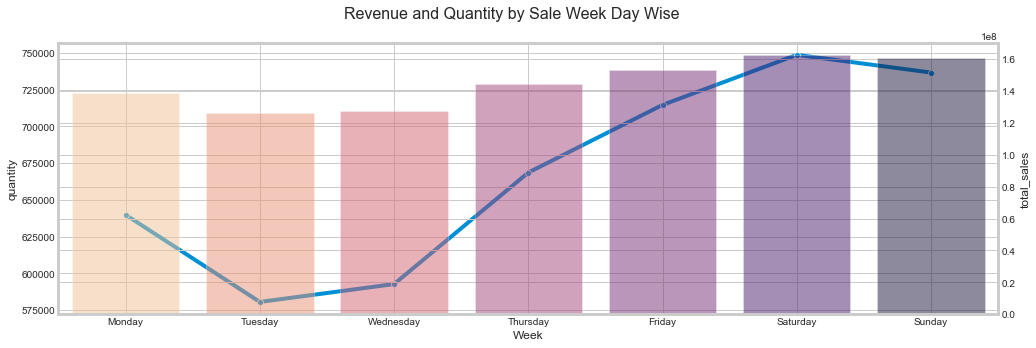

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
sns.set_style("whitegrid")

week = df[df['total_sales']>=0][['date_of_purchase','total_sales','quantity']]
week = week.groupby(week['date_of_purchase'].dt.weekday)[['total_sales','quantity']].sum()
week = week.reset_index()
week['Week'] = week['date_of_purchase'].apply(lambda x: calendar.day_name[x])

sns.lineplot(data = week, x=week['Week'], y='quantity', marker='o', sort = False, ax=ax, palette = 'magma_r')
ax2 = ax.twinx()
sns.barplot(data = week, x=week['Week'], y='total_sales', alpha=0.5, ax=ax2, palette = 'magma_r')
fig.suptitle('Revenue and Quantity by Sale Week Day Wise',fontsize=16)


plt.show()

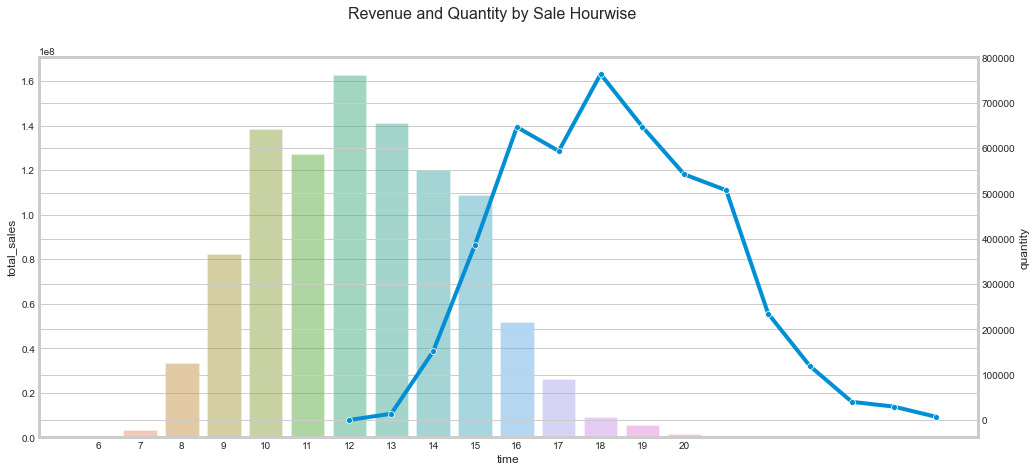

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

day = df[df['total_sales']>=0][['time','total_sales','quantity']]
day = day.groupby(day['time'].dt.hour)[['total_sales','quantity']].sum()

sns.barplot(data = day, x=day.index, y='total_sales', alpha=0.5, ax=ax)
ax2 = ax.twinx()
sns.lineplot(data = day, x=day.index, y='quantity', marker='o', sort = False, ax=ax2)
fig.suptitle('Revenue and Quantity by Sale Hourwise',fontsize=16)

plt.show()

In [31]:
df['time'].max()

Timestamp('1900-01-01 20:38:00')

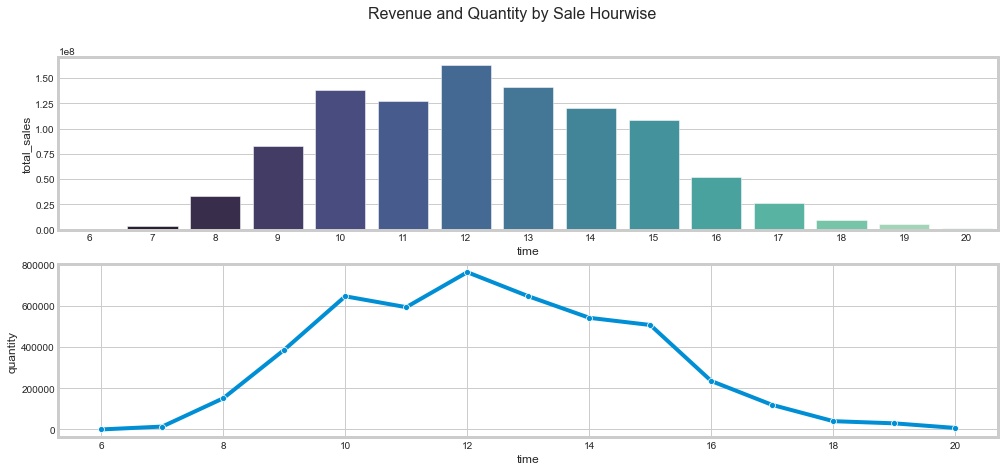

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

day = df[df['total_sales']>=0][['time','total_sales','quantity']]
day = day.groupby(day['time'].dt.hour)[['total_sales','quantity']].sum()

sns.barplot(data = day, x=day.index, y='total_sales', alpha=1, ax=ax[0], palette = 'mako')

sns.lineplot(data = day, x=day.index, y='quantity', marker='o', sort = False, ax=ax[1], palette = 'mako')
fig.suptitle('Revenue and Quantity by Sale Hourwise',fontsize=16)

plt.show()

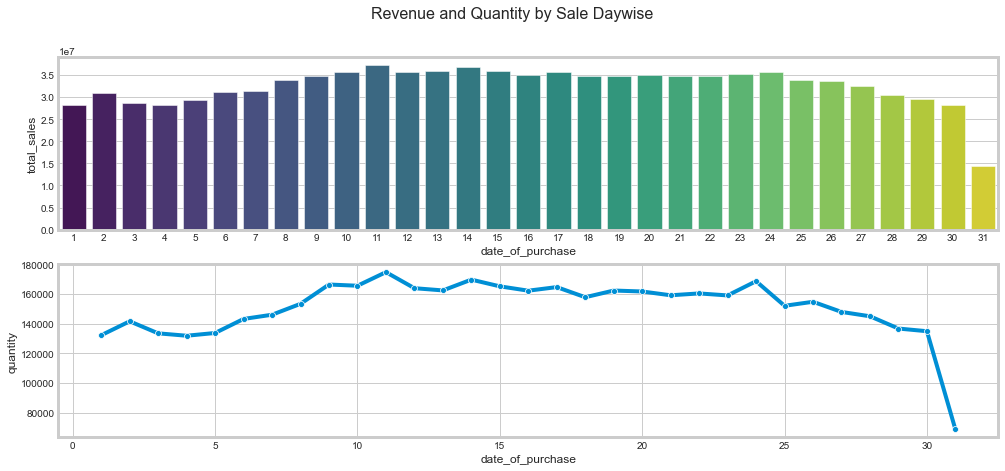

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

date = df[df['total_sales']>=0][['date_of_purchase','total_sales','quantity']]
date = date.groupby(date['date_of_purchase'].dt.day)[['total_sales','quantity']].sum()

sns.barplot(data = date, x=date.index, y='total_sales', alpha=1, ax=ax[0], palette = 'viridis')
sns.lineplot(data = date, x=date.index, y='quantity', marker='o', sort = False, ax=ax[1], palette = 'viridis')
fig.suptitle('Revenue and Quantity by Sale Daywise',fontsize=16)

plt.show()

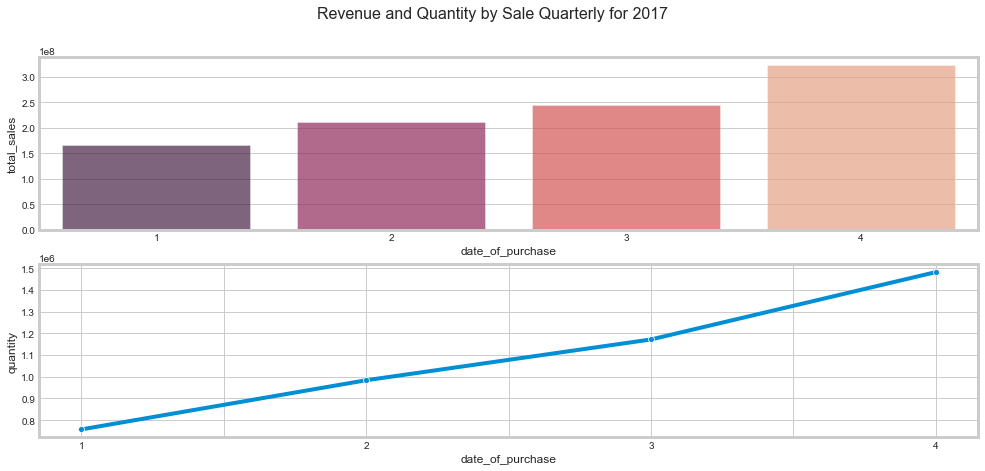

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

quarter = df[(df['total_sales']>=0)&(df['date_of_purchase'].dt.year==2017)][['date_of_purchase','total_sales','quantity']]
quarter = quarter.groupby(quarter['date_of_purchase'].dt.quarter)[['total_sales','quantity']].sum()

sns.barplot(data = quarter, x=quarter.index, y='total_sales', alpha=0.7, ax=ax[0], palette = 'rocket')
sns.lineplot(data = quarter, x=quarter.index, y='quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Quarterly for 2017',fontsize=16)

ax[1].set_xticklabels(['',1,'',2,'',3,'',4])
plt.show()

In [35]:
df['transactions_count'] = 1
df['holiday_season'] = 0

df.loc[df['date_of_purchase'].dt.month.isin([10,12]), 'holiday_season'] = 1
h1 = df[df['holiday_season']==1].groupby('item_code')['transactions_count'].sum()
h2 = df[df['holiday_season']==0].groupby('item_code')['transactions_count'].sum()
x = pd.DataFrame(data=[h1,h2]).T
x.columns = ['Season','Off-Season']
x = x.fillna(0)
x = x.reset_index()

In [36]:
x.head()

,item_code,Season,Off-Season
0,1983,1.0,0.0
1,2020,62.0,54.0
2,2425,16.0,33.0
3,2503,3.0,18.0
4,2543,10.0,20.0


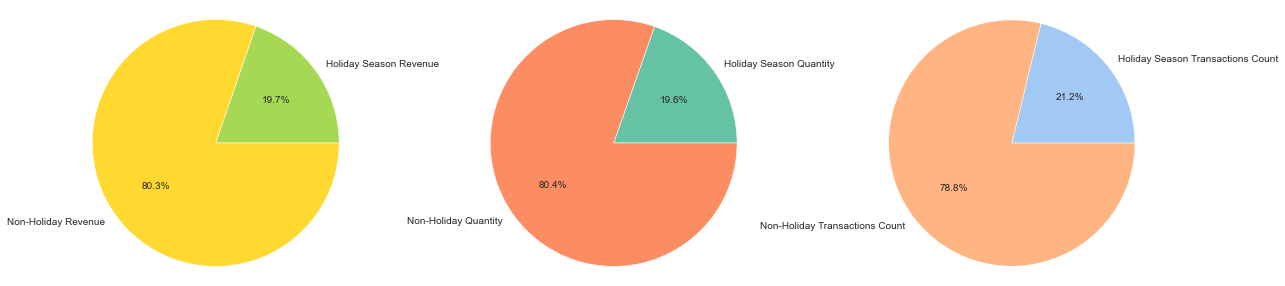

In [37]:
d = df[df['date_of_purchase'].dt.year==2017]
labels0 = ['Holiday Season Revenue', 'Non-Holiday Revenue']
sizes0 = [d[d['holiday_season']==1]['total_sales'].sum(),
         d[d['holiday_season']==0]['total_sales'].sum()
        ]

labels1 = ['Holiday Season Quantity', 'Non-Holiday Quantity']
sizes1 = [d[d['holiday_season']==1]['quantity'].sum(),
         d[d['holiday_season']==0]['quantity'].sum()
        ]

labels2 = ['Holiday Season Transactions Count', 'Non-Holiday Transactions Count']
sizes2 = [d[d['holiday_season']==1]['transactions_count'].sum(),
         d[d['holiday_season']==0]['transactions_count'].sum()
        ]


fig1, ax = plt.subplots(ncols=3,figsize=(18,5))
ax[0].pie(sizes0, labels=labels0, autopct='%1.1f%%', colors = sns.color_palette("Set2")[4:6])
ax[0].axis('equal')
ax[1].pie(sizes1, labels=labels1, autopct='%1.1f%%', colors = sns.color_palette("Set2")[0:2])
ax[1].axis('equal')
ax[2].pie(sizes2, labels=labels2, autopct='%1.1f%%', colors = sns.color_palette('pastel')[0:2])
ax[2].axis('equal')
plt.show()

<AxesSubplot:xlabel='return_reason', ylabel='count'>

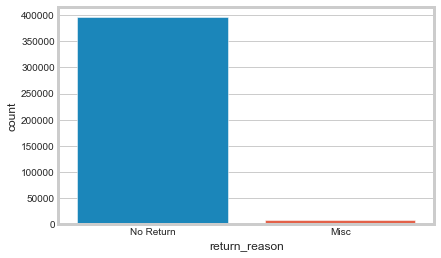

In [38]:
## Countplot

sns.countplot(df['return_reason'])

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404181 entries, 0 to 537949
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         404181 non-null  float64       
 1   item_code           404181 non-null  object        
 2   invoice_no          404181 non-null  int64         
 3   date_of_purchase    404181 non-null  datetime64[ns]
 4   quantity            404181 non-null  int64         
 5   time                404181 non-null  datetime64[ns]
 6   price_per_unit      404181 non-null  float64       
 7   total_sales         404181 non-null  float64       
 8   location            404181 non-null  object        
 9   is_cancelled        404181 non-null  object        
 10  return_reason       404181 non-null  object        
 11  invoice_date        404181 non-null  datetime64[ns]
 12  transactions_count  404181 non-null  int64         
 13  holiday_season      404181 no

### RFM Analysis

In [42]:
## New user data frame
recent_user = pd.DataFrame(df['customer_id'].unique())
recent_user.columns = ['customer_id']
recent_user.head()

,customer_id
0,4355.0
1,4352.0
2,4349.0
3,4343.0
4,4341.0


In [45]:
#get the max purchase date for each customer and create a dataframe with it
max_purchase = df.groupby('customer_id').invoice_date.max().reset_index()
max_purchase.columns = ['customer_id','max_purchase_date']
max_purchase.head()

,customer_id,max_purchase_date
0,2.0,2017-12-16 15:52:00
1,3.0,2017-10-04 13:13:00
2,4.0,2017-12-01 09:51:00
3,5.0,2017-02-12 16:01:00
4,6.0,2017-11-13 14:37:00


In [47]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
max_purchase['Recency'] = (max_purchase['max_purchase_date'].max() - max_purchase['max_purchase_date']).dt.days
max_purchase.head()

,customer_id,max_purchase_date,Recency
0,2.0,2017-12-16 15:52:00,2
1,3.0,2017-10-04 13:13:00,75
2,4.0,2017-12-01 09:51:00,18
3,5.0,2017-02-12 16:01:00,309
4,6.0,2017-11-13 14:37:00,35


In [48]:
#merge this dataframe to our new user dataframe
recent_user = pd.merge(recent_user, max_purchase[['customer_id','Recency']], on='customer_id')
recent_user.head()

,customer_id,Recency
0,4355.0,42
1,4352.0,38
2,4349.0,50
3,4343.0,6
4,4341.0,10


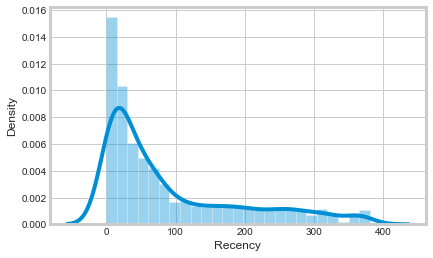

In [49]:
sns.distplot(recent_user['Recency']);

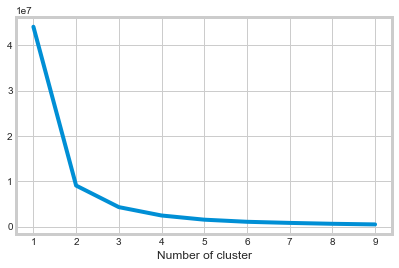

In [51]:
sse={} # error
user_recency = recent_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_recency)
    user_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [53]:
kmeans = KMeans(n_clusters=3)
recent_user['RecencyCluster'] = kmeans.fit_predict(recent_user[['Recency']])

In [54]:
recent_user.head()

,customer_id,Recency,RecencyCluster
0,4355.0,42,0
1,4352.0,38,0
2,4349.0,50,0
3,4343.0,6,0
4,4341.0,10,0


Ordering clusters

We have a cluster corresponding to each customerID. But each cluster is randomly assigned. Cluster 2 is not better than cluster 1 for e.g. and so on. We want to give clusters according to most recent transactions.

We will first find the mean of recency value corresponding to each cluster. Then we will sort these values. Let's say cluster 2 has the most recent transactions mean value.

In [55]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

recent_user = order_cluster('RecencyCluster', 'Recency',recent_user,False)

In [56]:
recent_user.head()

,customer_id,Recency,RecencyCluster
0,4355.0,42,2
1,4352.0,38,2
2,4349.0,50,2
3,4343.0,6,2
4,4341.0,10,2


In [60]:
frequent_user = df.groupby('customer_id').invoice_date.count().reset_index()
frequent_user.columns = ['customer_id','Frequency']

In [58]:
frequent_user.head()

,CustomerID,Frequency
0,2.0,182
1,3.0,27
2,4.0,72
3,5.0,16
4,6.0,84


In [61]:
recent_user = pd.merge(recent_user, frequent_user, on='customer_id')
recent_user.head()

,customer_id,Recency,RecencyCluster,Frequency
0,4355.0,42,2,21
1,4352.0,38,2,122
2,4349.0,50,2,98
3,4343.0,6,2,177
4,4341.0,10,2,105


C:\Users\musta\AppData\Local\Temp/ipykernel_7856/981708015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_frequency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
C:\Users\musta\AppData\Local\Temp/ipykernel_7856/981708015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_frequency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
C:\Users\musta\AppData\Local\Temp/ipykernel_7856/981708015.py:5: SettingWithCopyWarning: 
A value is tryin

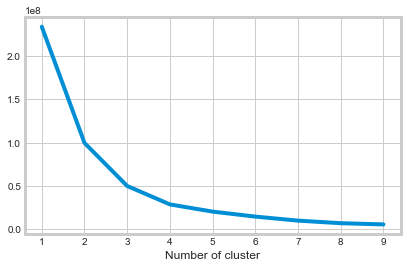

In [62]:
sse={} # error
user_frequency = recent_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_frequency)
    user_frequency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [63]:
kmeans=KMeans(n_clusters=3)
recent_user['FrequencyCluster']=kmeans.fit_predict(recent_user[['Frequency']])

#order the frequency cluster
recent_user = order_cluster('FrequencyCluster', 'Frequency', recent_user, True )
recent_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4075.0,60.024049,60.518642,1.0,16.00,37.0,85.00,281.0
1,270.0,503.796296,324.414553,282.0,325.25,404.0,542.75,2779.0
2,4.0,5889.500000,1480.761178,4615.0,4978.00,5486.5,6398.00,7970.0


In [64]:
recent_user.head()

,customer_id,Recency,RecencyCluster,Frequency,FrequencyCluster
0,4355.0,42,2,21,0
1,4352.0,38,2,122,0
2,4349.0,50,2,98,0
3,4343.0,6,2,177,0
4,4341.0,10,2,105,0
